## Munting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# leukemia Detection

"""
1. MM (Multiple Myeloma)
2. Healthy
3. CML (Chronic Myeloid Leukemia)
4. CLL (Chronic Lymphocytic Leukemia)
5. AML (Acute Myeloid Leukemia)
6. ALL (Acute Lymphoblastic Leukemia)
"""

# Data Splitting

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source and destination directories
source_dir = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001/Dataset"
output_dir = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001/split_dataset"
categories = ["ALL", "AML", "CLL","MM","Healthy","CML"]  # Subfolders for each class
split_ratios = (0.6, 0.2, 0.2)  # Train, validation, test split ratios

# Create destination directories for train, val, and test
for split in ["train", "val", "test"]:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split the data for each category
for category in categories:
    category_path = os.path.join(source_dir, category)
    images = os.listdir(category_path)

    # Train-Validation-Test Split
    train_files, temp_files = train_test_split(images, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(split_ratios[2] / (split_ratios[1] + split_ratios[2])), random_state=42)

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "train", category, file))
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "val", category, file))
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "test", category, file))

print("Dataset split completed!")


## Data Loading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
/content/drive/MyDrive/CV assessment-20250114T040851Z-001/Dataset

In [3]:
# Define the path to your local dataset directory
dataset_dir = '/content/drive/MyDrive/CV assessment-20250114T040851Z-001/Dataset'
data_dir = pathlib.Path(dataset_dir)

# Set parameters for loading the data
batch_size = 32
img_height = 180
img_width = 180

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 2400 files belonging to 6 classes.
Using 1920 files for training.
Found 2400 files belonging to 6 classes.
Using 480 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['ALL', 'AML', 'CLL', 'CML', 'Healthy', 'MM']


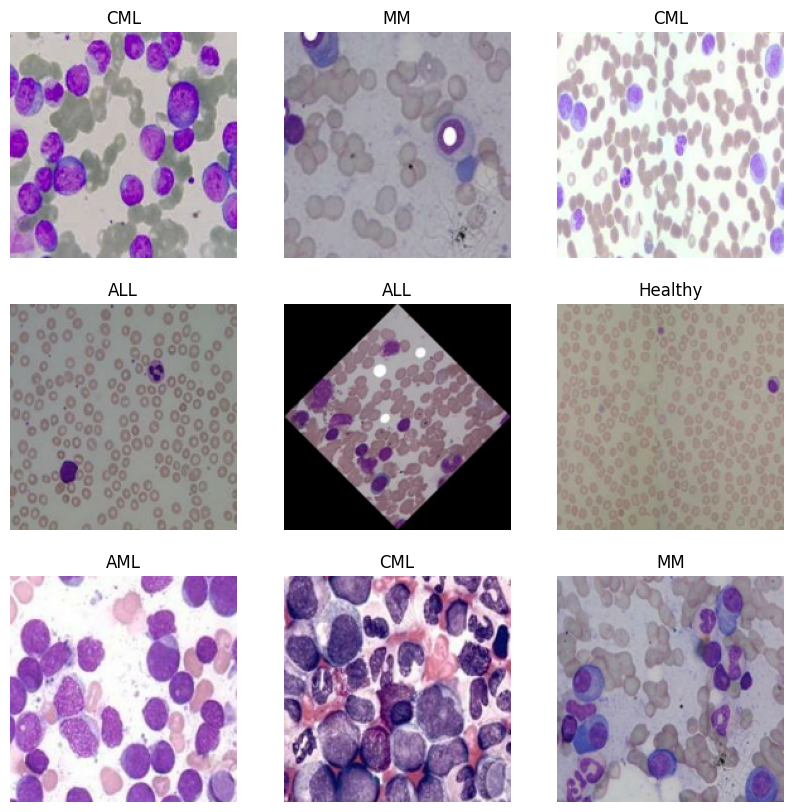

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.078503385 1.0


In [48]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(6, activation='softmax'),
  layers.Dense(num_classes)
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │         185,862 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,488 (818.31 KB)

 Trainable params: 209,488 (818.31 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1701 - loss: 1.8210 - val_accuracy: 0.1625 - val_loss: 1.8012
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1872 - loss: 1.7981 - val_accuracy: 0.1625 - val_loss: 1.7966
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1633 - loss: 1.7942 - val_accuracy: 0.1625 - val_loss: 1.7944
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1633 - loss: 1.7973 - val_accuracy: 0.1625 - val_loss: 1.7929
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1668 - loss: 1.7926 - val_accuracy: 0.1625 - val_loss: 1.7924
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.1467 - loss: 1.7947 - val_accuracy: 0.1625 - val_loss: 1.7919
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.1673 - loss: 1.7925 - val_accuracy: 0.1625 - val_loss: 1.7919
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1760 - loss: 1.7921 - val_accuracy: 0.1625 - val_loss:

In [35]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/CV assessment-20250114T040851Z-001/modelWithoutAug.keras')

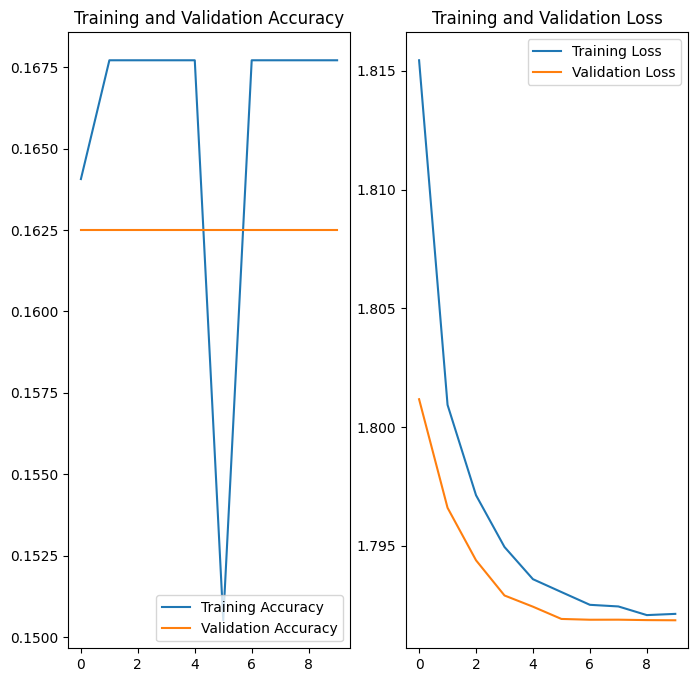

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/CV assessment-20250114T040851Z-001/linearmodelAug.keras')

These approach with Augmentation

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


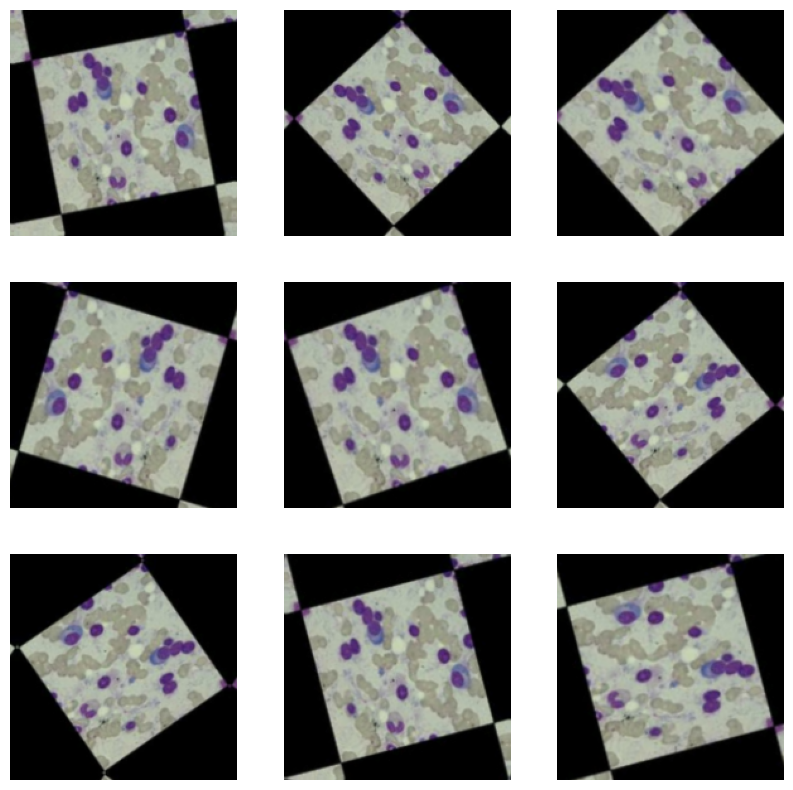

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(6, activation='softmax'),
  layers.Dense(num_classes, name="outputs")
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │         185,862 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,488 (818.31 KB)

 Trainable params: 209,488 (818.31 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.1441 - loss: 1.8073 - val_accuracy: 0.1771 - val_loss: 1.7923
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2031 - loss: 1.7699 - val_accuracy: 0.2542 - val_loss: 1.7510
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2137 - loss: 1.7353 - val_accuracy: 0.1792 - val_loss: 1.6945
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2586 - loss: 1.6521 - val_accuracy: 0.3042 - val_loss: 1.6096
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3039 - loss: 1.5856 - val_accuracy: 0.2542 - val_loss: 1.5564
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2896 - loss: 1.5382 - val_accuracy: 0.2937 - val_loss: 1.5072
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2865 - loss: 1.5017 - val_accuracy: 0.3000 - val_loss: 1.4728
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3046 - loss: 1.4575 - val_accuracy: 0.3417 - val_loss

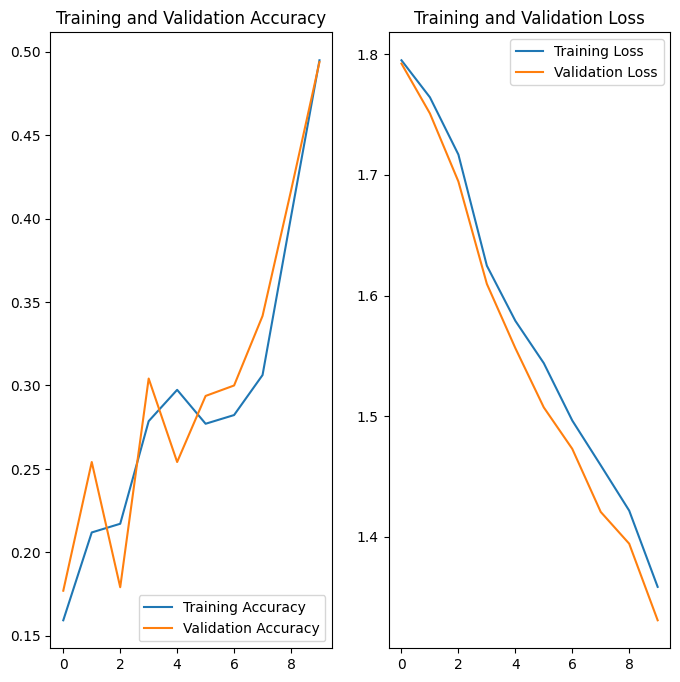

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/CV assessment-20250114T040851Z-001/RelumodelAug.keras')

## Transfer Learning

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Loader

In [86]:
# Define the paths to your local dataset directories
local_dataset_path = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001"  # Update this path
train_dir = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001/split_dataset/test"
validation_dir = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001/split_dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)




Found 480 files belonging to 6 classes.
Found 480 files belonging to 6 classes.


In [97]:
test_dir = "/content/drive/MyDrive/CV assessment-20250114T040851Z-001/split_dataset/test"

In [98]:
# Load validation dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 480 files belonging to 6 classes.


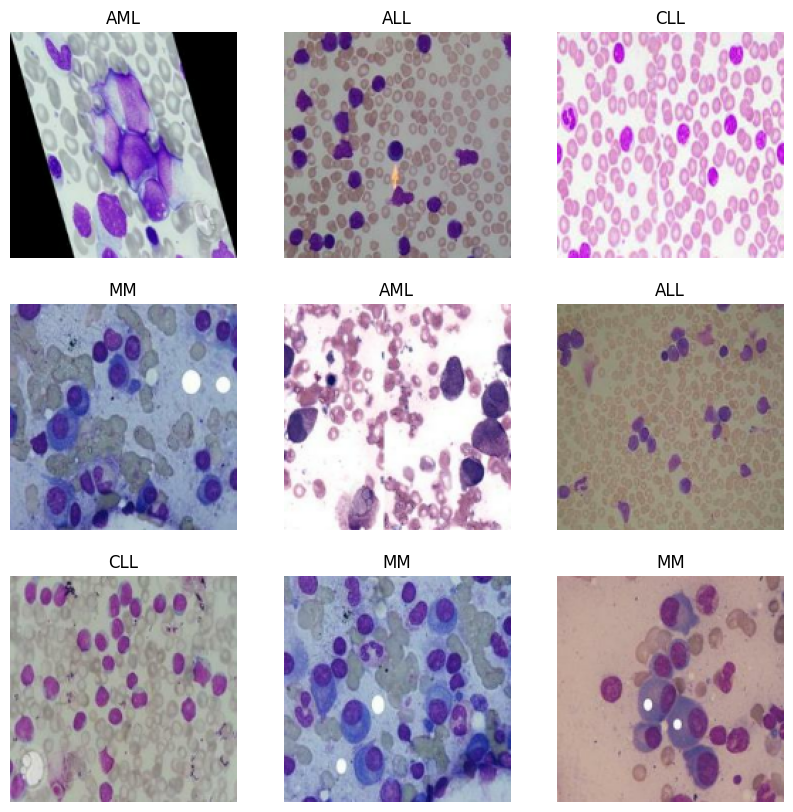

In [87]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Using Transfer Learning

## Using DenseNet weight

### without connected layer

In [88]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt


In [89]:
# Load the DenseNet121 base model
base_model = DenseNet121(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom classification head
global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(0.2)
prediction_layer = layers.Dense(6, activation='softmax')  # 6 classes

# Build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)  # Disable training for base model
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [90]:
# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 265s 17s/step - accuracy: 0.2034 - loss: 9.7220 - val_accuracy: 0.2688 - val_loss: 4.0471
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.2805 - loss: 5.2573 - val_accuracy: 0.4479 - val_loss: 2.4463
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.3562 - loss: 4.2141 - val_accuracy: 0.4875 - val_loss: 2.0365
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.4451 - loss: 3.3978 - val_accuracy: 0.5458 - val_loss: 1.7947
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.4649 - loss: 3.5211 - val_accuracy: 0.5333 - val_loss: 1.9589
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 125s 9s/step - accuracy: 0.4457 - loss: 3.1282 - val_accuracy: 0.5813 - val_loss: 1.6994
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 9s/step - accuracy: 0.4676 - loss: 3.1292 - val_accuracy: 0.6000 - val_loss: 1.4452
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.5624 - loss: 2.2909 - val_accuracy: 0.5792 - 

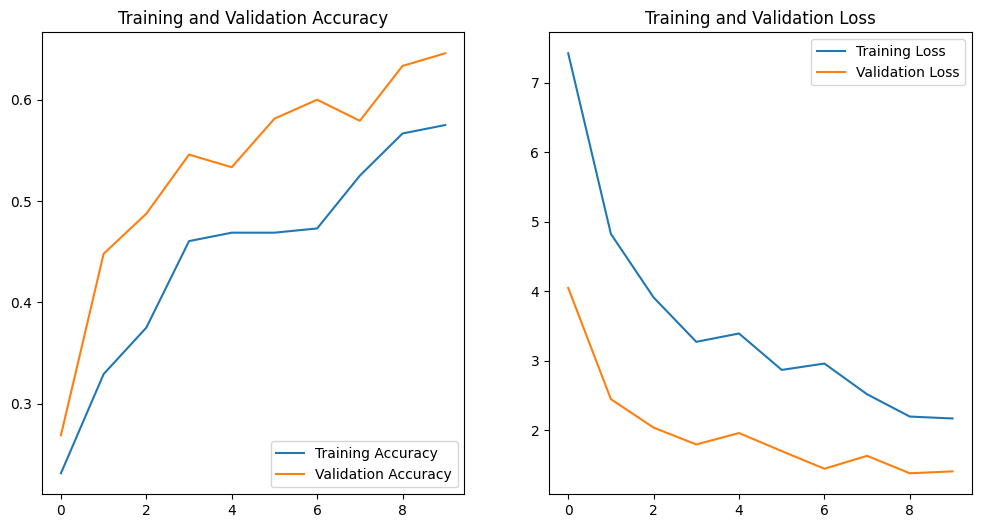

In [92]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step


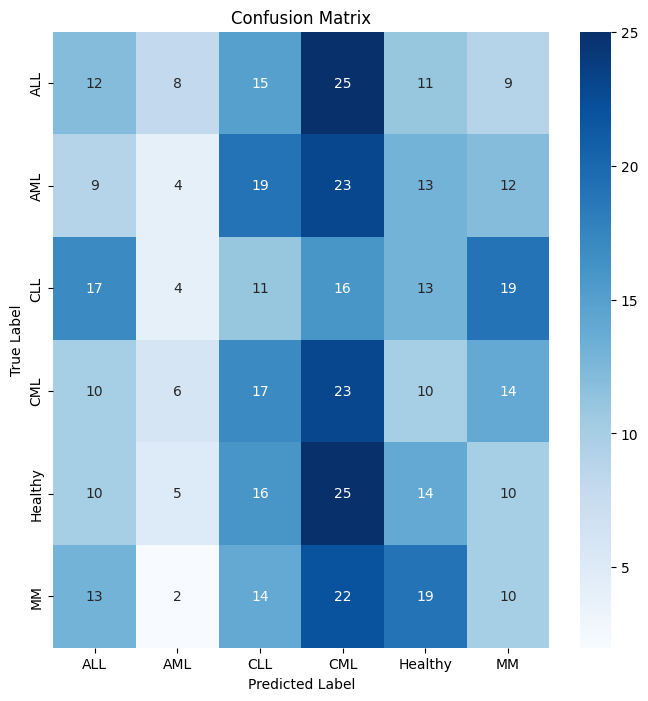

In [94]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_dataset.class_names

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step


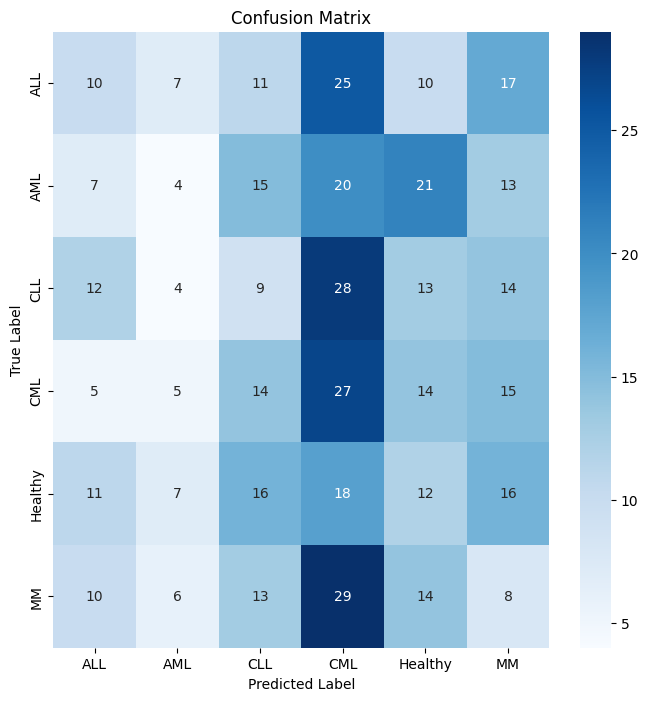

In [99]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_dataset.class_names

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


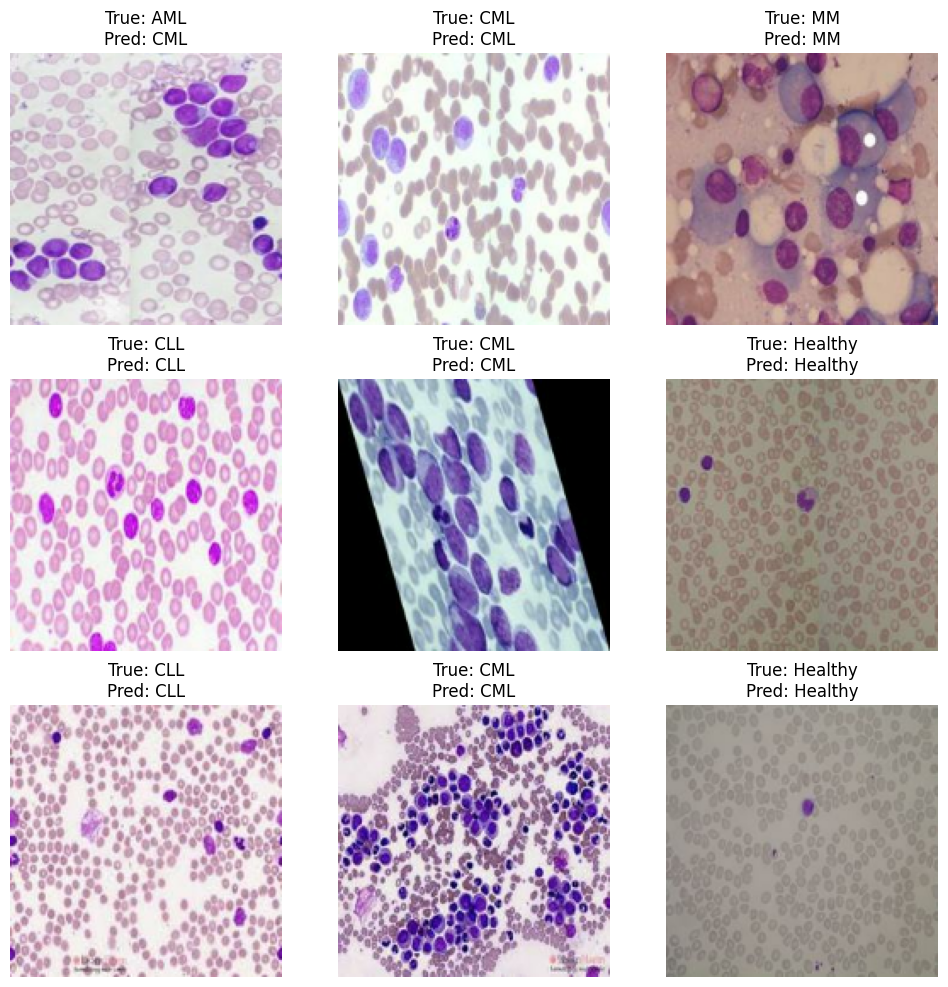

In [100]:
# Display sample predictions
plt.figure(figsize=(12, 12))
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.show()


In [101]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

         ALL       0.18      0.12      0.15        80
         AML       0.12      0.05      0.07        80
         CLL       0.12      0.11      0.11        80
         CML       0.18      0.34      0.24        80
     Healthy       0.14      0.15      0.15        80
          MM       0.10      0.10      0.10        80

    accuracy                           0.15       480
   macro avg       0.14      0.15      0.14       480
weighted avg       0.14      0.15      0.14       480



# With connected layer

In [112]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the DenseNet121 base model
base_model = DenseNet121(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)


# Freeze the base model
base_model.trainable = False

# Add custom classification head
global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(0.2)
dense_layer_1 = layers.Dense(1024, activation='relu')
dense_layer_2 = layers.Dense(512, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')  # 6 classes for your classification task

# Build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)  # Disable training for base model
x = global_average_layer(x)
x = dropout_layer(x)
x = dense_layer_1(x)
x = dense_layer_2(x)
outputs = prediction_layer(x)

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,614,982 (32.86 MB)

 Trainable params: 1,577,478 (6.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [113]:
# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 9s/step - accuracy: 0.2449 - loss: 11.7700 - val_accuracy: 0.4688 - val_loss: 2.7532
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 9s/step - accuracy: 0.4653 - loss: 2.5142 - val_accuracy: 0.5542 - val_loss: 1.2775
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.5435 - loss: 1.3048 - val_accuracy: 0.5688 - val_loss: 1.2455
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.5563 - loss: 1.1773 - val_accuracy: 0.6313 - val_loss: 1.0447
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.6621 - loss: 0.9312 - val_accuracy: 0.6396 - val_loss: 1.0792
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 9s/step - accuracy: 0.6310 - loss: 1.0093 - val_accuracy: 0.6521 - val_loss: 0.9443
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.6864 - loss: 0.8847 - val_accuracy: 0.6167 - val_loss: 0.9443
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.6884 - loss: 0.8822 - val_accuracy: 0.6458 - 

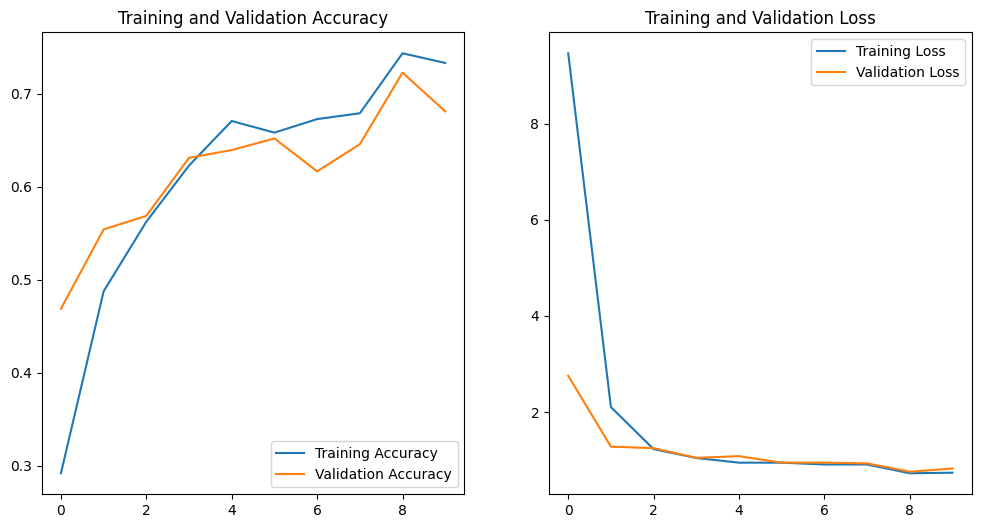

In [114]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step


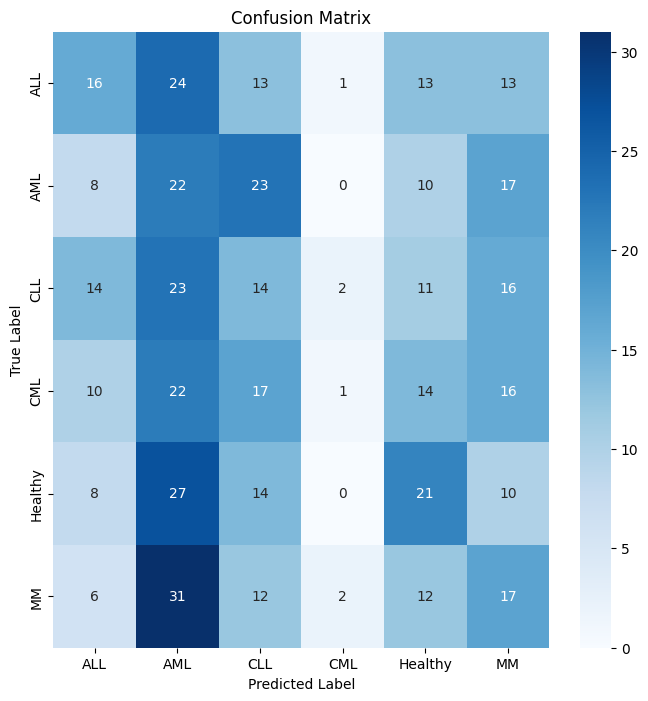

In [115]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_dataset.class_names

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


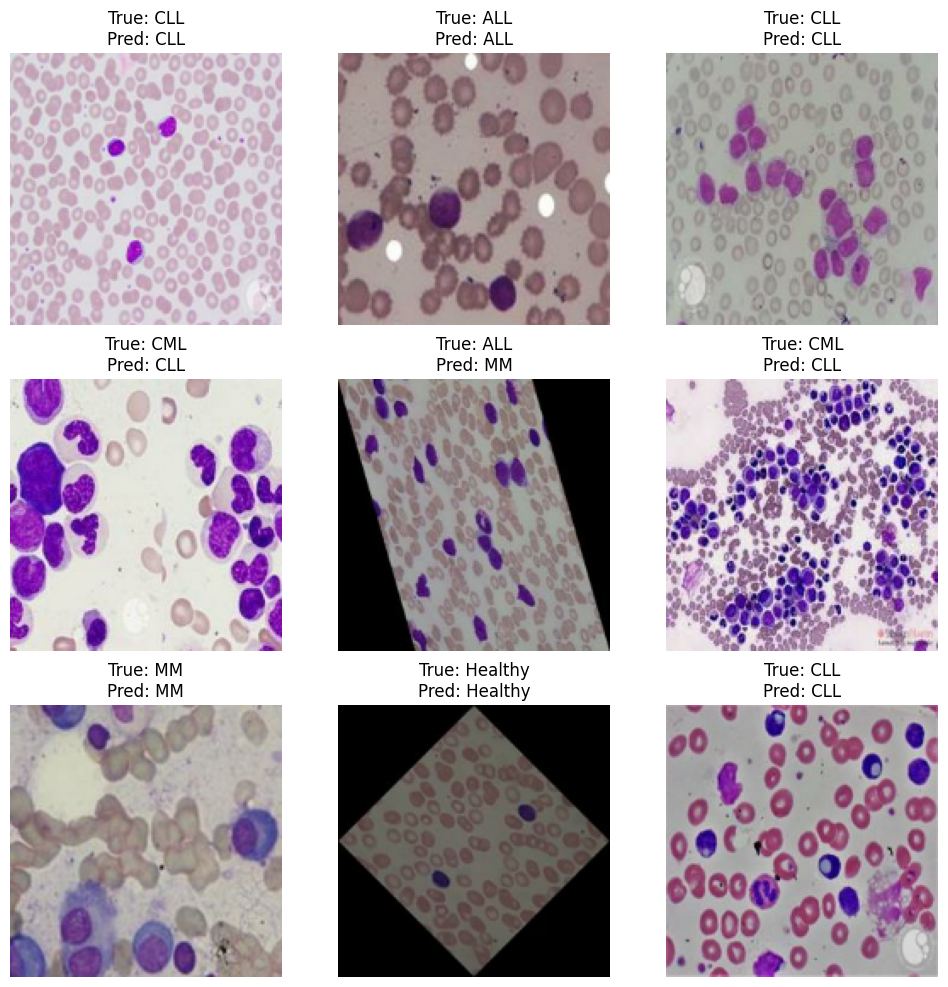

In [116]:
# Display sample predictions
plt.figure(figsize=(12, 12))
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.show()


In [117]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

         ALL       0.26      0.20      0.23        80
         AML       0.15      0.28      0.19        80
         CLL       0.15      0.17      0.16        80
         CML       0.17      0.01      0.02        80
     Healthy       0.26      0.26      0.26        80
          MM       0.19      0.21      0.20        80

    accuracy                           0.19       480
   macro avg       0.20      0.19      0.18       480
weighted avg       0.20      0.19      0.18       480



## Fine Tunning Model

In [118]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train again
fine_tune_epochs = 5
history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=fine_tune_epochs
)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 354s 16s/step - accuracy: 0.1828 - loss: 2.0346 - val_accuracy: 0.2708 - val_loss: 1.7708
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 252s 16s/step - accuracy: 0.2781 - loss: 1.6784 - val_accuracy: 0.3000 - val_loss: 1.6940
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 254s 15s/step - accuracy: 0.3960 - loss: 1.4067 - val_accuracy: 0.3438 - val_loss: 1.5972
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 265s 15s/step - accuracy: 0.4563 - loss: 1.3004 - val_accuracy: 0.3708 - val_loss: 1.5033
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 263s 15s/step - accuracy: 0.5782 - loss: 1.1646 - val_accuracy: 0.4167 - val_loss: 1.3984


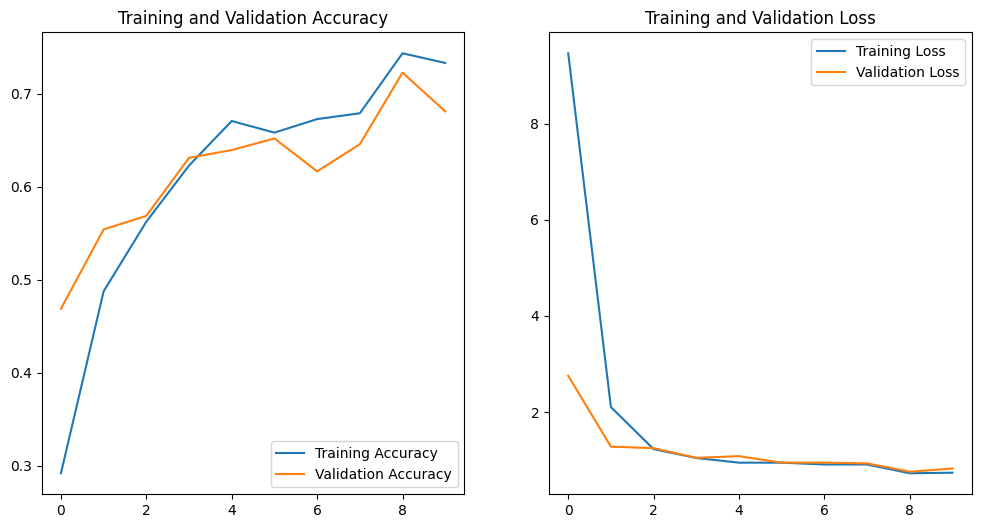

In [119]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


#Resnet

In [104]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the image size and shape
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom classification head
global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(0.2)
dense_layer_1 = layers.Dense(1024, activation='relu')
dense_layer_2 = layers.Dense(512, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')  # 6 classes for your classification task

# Build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)  # Disable training for base model
x = global_average_layer(x)
x = dropout_layer(x)
x = dense_layer_1(x)
x = dense_layer_2(x)
outputs = prediction_layer(x)

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print the model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,213,766 (100.00 MB)

 Trainable params: 2,626,054 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [105]:
# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 156s 10s/step - accuracy: 0.3802 - loss: 2.5175 - val_accuracy: 0.6521 - val_loss: 0.8315
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.6284 - loss: 0.8595 - val_accuracy: 0.7333 - val_loss: 0.6459
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.7313 - loss: 0.6041 - val_accuracy: 0.7312 - val_loss: 0.5768
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.8348 - loss: 0.4215 - val_accuracy: 0.7021 - val_loss: 0.6742
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.7996 - loss: 0.4538 - val_accuracy: 0.7167 - val_loss: 0.6549
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - accuracy: 0.8698 - loss: 0.3562 - val_accuracy: 0.7688 - val_loss: 0.6282
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.8510 - loss: 0.3383 - val_accuracy: 0.7646 - val_loss: 0.5597
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.9161 - loss: 0.2843 - val_accuracy: 0.7833 - 

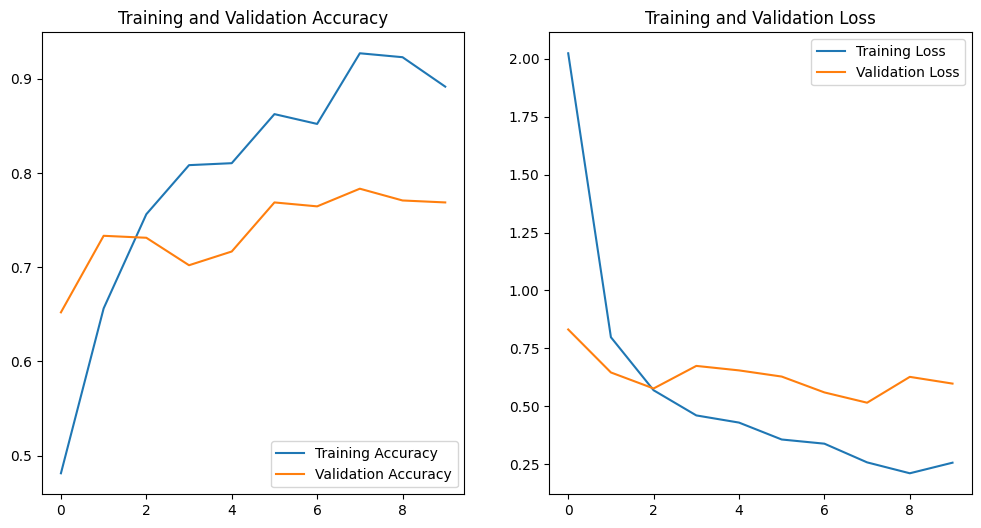

In [106]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step


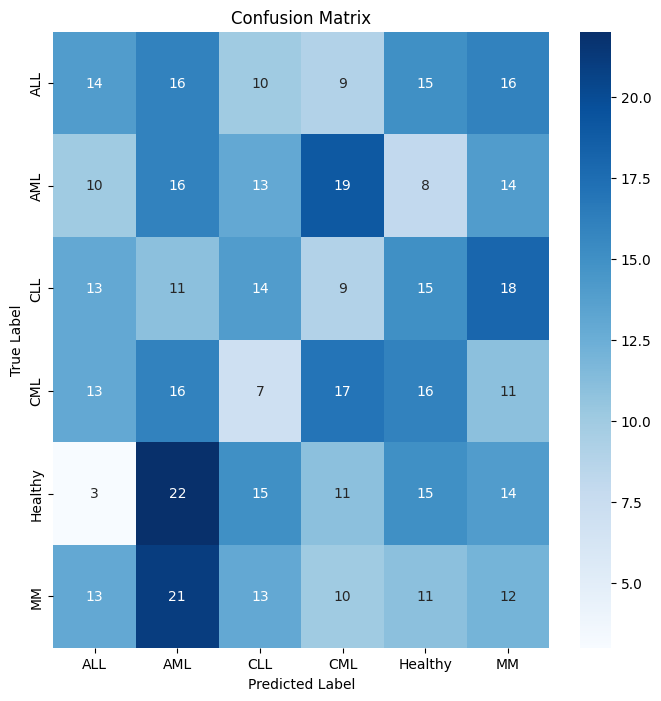

In [107]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_dataset.class_names

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


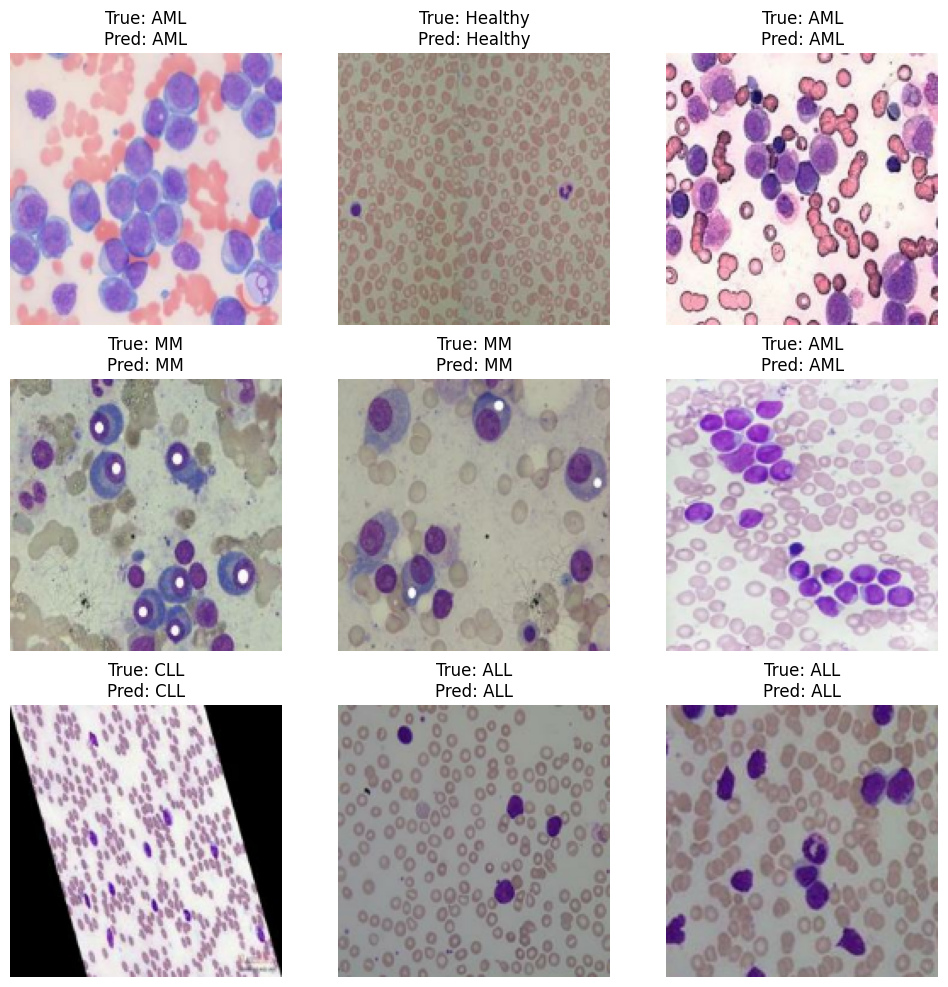

In [108]:
# Display sample predictions
plt.figure(figsize=(12, 12))
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.show()


In [109]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

         ALL       0.21      0.17      0.19        80
         AML       0.16      0.20      0.18        80
         CLL       0.19      0.17      0.18        80
         CML       0.23      0.21      0.22        80
     Healthy       0.19      0.19      0.19        80
          MM       0.14      0.15      0.15        80

    accuracy                           0.18       480
   macro avg       0.19      0.18      0.18       480
weighted avg       0.19      0.18      0.18       480



## Fine tuning Model

In [110]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train again
fine_tune_epochs = 5
history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=fine_tune_epochs
)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 354s 20s/step - accuracy: 0.4459 - loss: 1.9660 - val_accuracy: 0.7729 - val_loss: 0.5937
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 323s 20s/step - accuracy: 0.6270 - loss: 1.0832 - val_accuracy: 0.7750 - val_loss: 0.6413
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 290s 20s/step - accuracy: 0.7615 - loss: 0.6048 - val_accuracy: 0.7646 - val_loss: 0.6921
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 327s 20s/step - accuracy: 0.8687 - loss: 0.3470 - val_accuracy: 0.7479 - val_loss: 0.7358
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 321s 20s/step - accuracy: 0.9001 - loss: 0.2582 - val_accuracy: 0.7479 - val_loss: 0.7568


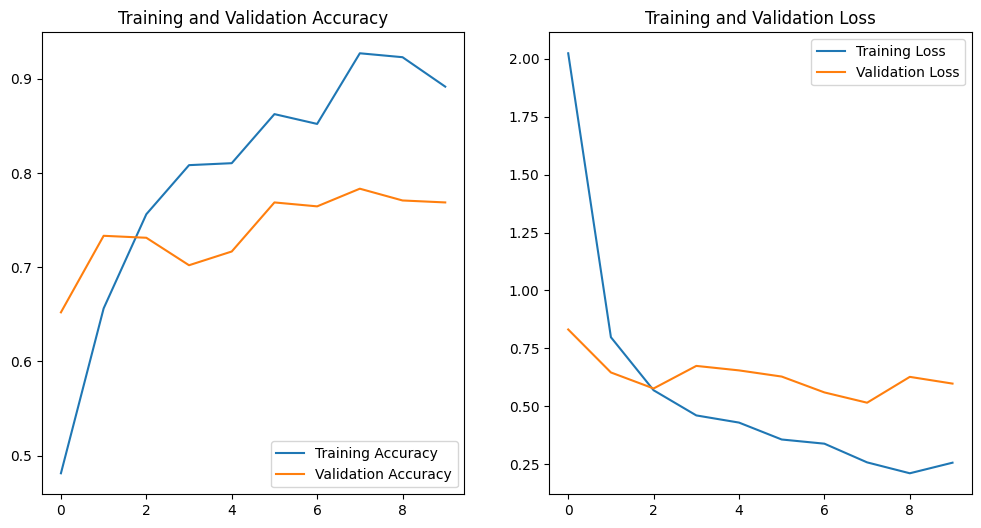

In [111]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
